# Plot water stress

## 1. Settings

In [13]:
# laod modules 
import xarray as xr
import matplotlib.pyplot as plt
import os
import regionmask 
import pandas as pd
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors


# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import * #info on ctsm utils: https://github.com/NCAR/ctsm_python_gallery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [14]:
# directory settings

# set directories
outdir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/'
figdir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/Vanderkelen_etal_2025_BG/figures/'
datadir = '/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/innev/4p1000/Vanderkelen_etal_2025_data_topublish/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

# define scenario
scenario = '4p1000'
scenarios = ['4p1000', 'high', 'medium']

# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

case   = case_ctl
block  = 'lnd' 
stream = 'h1' 

# List of variables to import from file(s) in $indir matching $pattern.
variables = ['H2OSOI',"TOTSOILLIQ","TOTSOILICE", "QINFL" , "QOVER", "QDRAI", 'EFLX_LH_TOT',  "watsat","QROOTSINK" ,"QVEGE", "QVEGT","QSOIL",
             "watfc", "EFF_POROSITY", ] #"SOILPSI", "FPSN","QHR","SMP","GSSHA","GSSUN"

# discard 2004 until 2008 as spin up years
start_year, end_year = 1995, 2014 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-01")

proj =  ccrs.PlateCarree()


In [15]:
## settings for plotting
ds_ctl =  load_case_ctl(['H2OSOI'])

# get mask and region ids
exclude_ids = np.array([0,1,2,16,28,29,30,31])
mask_regions = regionmask.defined_regions.ar6.land.mask(ds_ctl['H2OSOI'])

region_ids = np.arange(0,44)
region_ids = np.delete(region_ids, exclude_ids)
region_ids_sel = [3,19,23]

regions_sand_clay = [6, 7, 10, 11, 12, 14, 19, 21, 22, 23, 24, 26, 37, 38, 39, 41]

plotting_depth = 1 # m 8
figsize = (17,38)

labels = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.']

# get pfts modelled - bare soil, grassland and crop pfts
pft_list_crops = [15,16]
pft_list_grassland = [0,12,13,14]

pft_int = 15

### Load auxiliary data (soil levels, input dataset, wilting point etc) 

In [16]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()

# get info on soil levels
levsoi = ds_ctl['levsoi'].values
levgrnd = ds_ctl['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

# input data
# define variables to load from input dataset
input_variables = ['ORGANIC','PFTDATA_MASK','PCT_SAND','PCT_CLAY', 'PCT_CFT','PCT_CROP']

# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata(scenario, input_variables, case_ctl)

da_irrigated_mask = ds_input['PCT_CFT'].sel(cft=16)>0

da_cropland_mask = ds_input['PCT_CROP']>0


## Plot cumulative water stress (upper 60 cm)

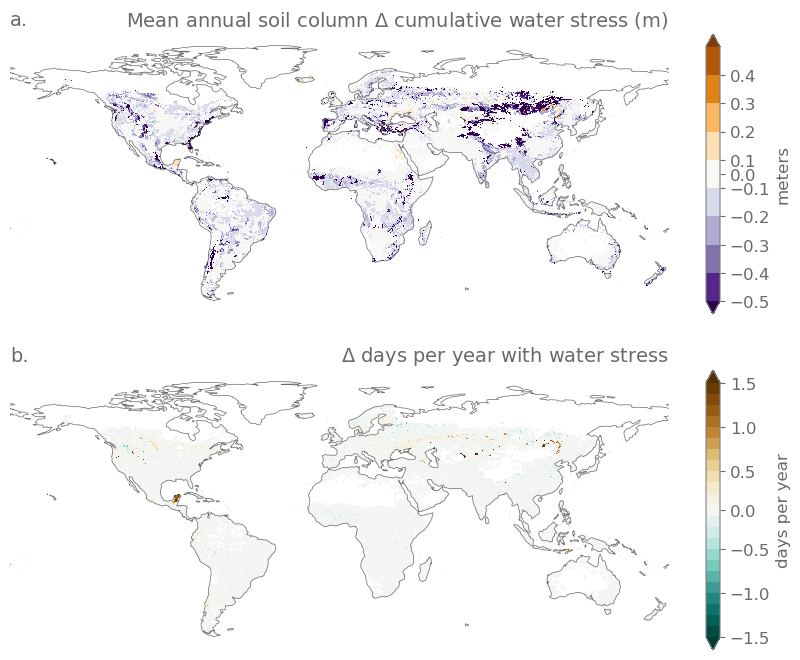

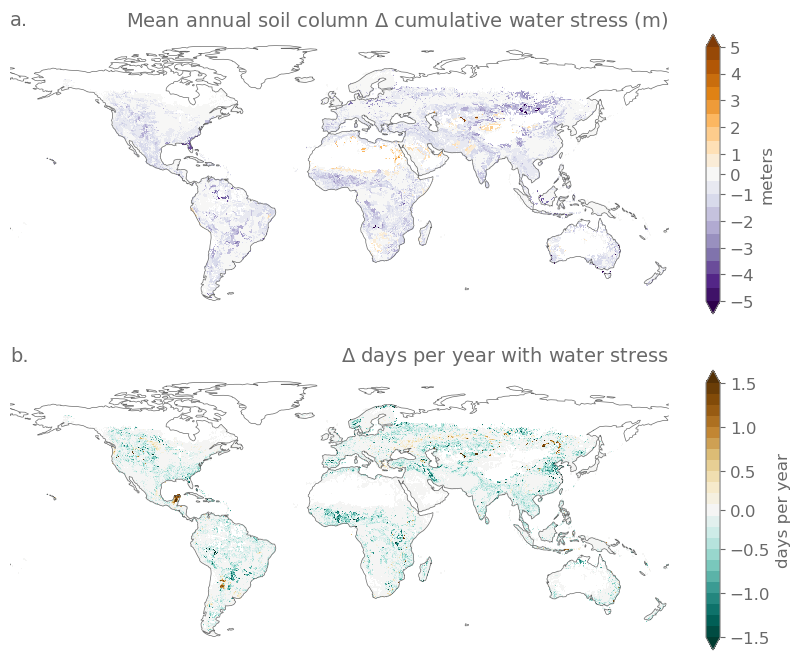

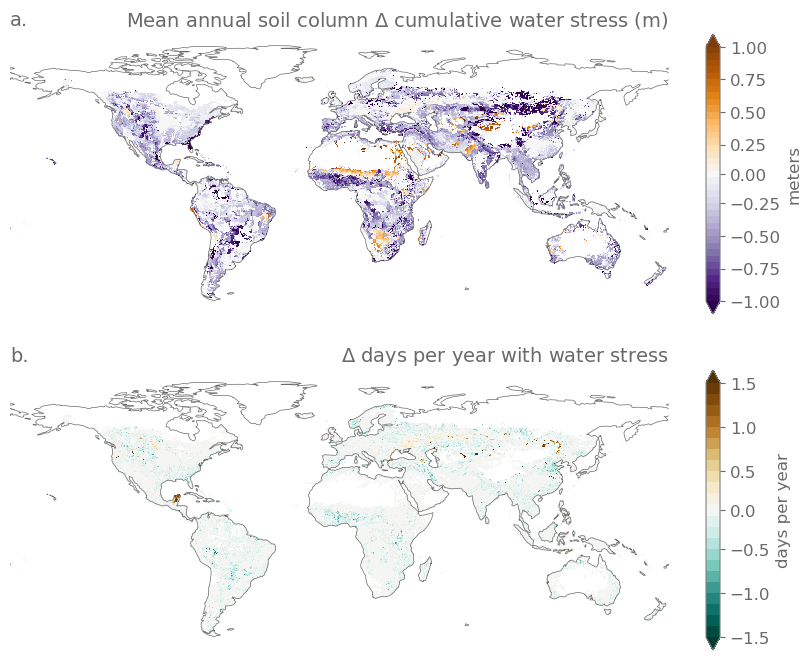

In [18]:

d_vlims = {'high' : [-5,5], 
           'medium' : [-1,1], 
           '4p1000':  [-0.5,0.5]}
    
d_nsteps = {'high' : 0.5,
            'medium' : 0.05,
            '4p1000':  0.1}

d_ticks = {'high' : np.arange(-5,6,1),
         'medium' : np.arange(-1,1.25,0.25),
         '4p1000':  np.arange(-0.5,0.5,0.1)}

for scenario in scenarios: 
    case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'
    case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

    variable = "H2OSOI" 

    da_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable).isel(levsoi=range(0,10))
    da_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable).isel(levsoi=range(0,10))

    da_wilting_h2osoi, da_wilting_h2osoi_scen = load_wilting_h2osoi(scenario)

    da_wilting_h2osoi['levsoi'] = da_ctl.levsoi.isel(levsoi=range(0,10))
    da_wilting_h2osoi_scen['levsoi'] = da_scen.levsoi.isel(levsoi=range(0,10))

    da_stress_cumulative_ctl  = calc_annual_cumulative_stress(da_ctl,  da_wilting_h2osoi) 
    da_stress_cumulative_scen = calc_annual_cumulative_stress(da_scen, da_wilting_h2osoi_scen) 

    da_delta_stress = (da_stress_cumulative_scen - da_stress_cumulative_ctl).mean('year').squeeze().compute()

    da_delta_stress_mm = (da_delta_stress*np.expand_dims(np.expand_dims(levsoi_thickness[0:10], axis=1), axis=2)*1000).sum('levsoi')
    da_delta_stress_mm_upper60cm = (da_delta_stress[0:7,:,:]*np.expand_dims(np.expand_dims(levsoi_thickness[0:7], axis=1), axis=2)*1000).sum('levsoi')

    fig, axes = plt.subplots(2,1,figsize=(12,8),subplot_kw={'projection': proj, 'frameon':False})

    axes = axes.flatten()

    ax = axes[0]
    label = labels[0]
    vlims = d_vlims[scenario]
    nstep= d_nsteps[scenario]
    levels = np.arange(vlims[0],vlims[1]+nstep, nstep)
    levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))
    ticks = d_ticks[scenario] 



    (da_delta_stress_mm_upper60cm*10e-3).where(da_cropland_mask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': 'meters', 'fraction': 0.02, 'pad': 0.04, 'ticks':ticks}, levels=levels)
    
    # Overlay the gray mask for non cropland regions
    gray_mask = (da_cropland_mask.where(da_cropland_mask)==0).astype(int)
    gray_cmap = mcolors.ListedColormap(['none', 'lightgray'])
    gray_norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5], gray_cmap.N)
    gray_mask.plot( ax=ax, cmap=gray_cmap, norm=gray_norm, add_colorbar=False )


    ax.set_title(' ', loc='center')
    ax.set_title(label, loc='left')
    ax.set_title('Mean annual soil column $\Delta$ cumulative water stress (m)', loc='right')
    ax.coastlines(color='dimgray', linewidth=0.5)
    ax.set_extent((-180,180,-63,90), crs=proj);
    ax.axis('off');


    ## days with water stress

    da_stress_days_ctl  = calc_days_per_year_with_stress(da_ctl, da_wilting_h2osoi)
    da_stress_days_scen = calc_days_per_year_with_stress(da_scen, da_wilting_h2osoi) 

    da_delta_stress_days = (da_stress_days_scen - da_stress_days_ctl).mean('year').squeeze().compute()
    #da_delta_stress_days_dryyear = da_stress_days_scen.max('year')  - da_stress_days_ctl.max('year') 

    ax = axes[1]
    label = labels[1]


    vlims = [-1.5,1.5]
    nstep= 0.125
    levels = np.arange(vlims[0],vlims[1]+nstep, nstep)
    levels = np.concatenate((levels[:int((len(levels)-1)/2)], levels[int((len(levels)-1)/2)+1:]))
    ticks = np.arange(-1.5,2,0.5)

    (da_delta_stress_days).where(da_cropland_mask).plot(ax=ax, cmap='BrBG_r', cbar_kwargs={'label': 'days per year', 'fraction': 0.02, 'pad': 0.04, 'ticks':ticks}, levels=levels)
    # Overlay the gray mask
    gray_mask = (da_cropland_mask.where(da_cropland_mask)==0).astype(int)

    # Plot the gray mask
    # Create a custom colormap for the gray mask
    gray_cmap = mcolors.ListedColormap(['none', 'lightgray'])
    gray_norm = mcolors.BoundaryNorm([-0.5, 0.5, 1.5], gray_cmap.N)
    gray_mask.plot( ax=ax, cmap=gray_cmap, norm=gray_norm, add_colorbar=False )


    ax.set_title(' ', loc='center')
    ax.set_title('$\Delta$ days per year with water stress', loc='right')
    ax.set_title(label, loc='left')

    ax.coastlines(color='dimgray', linewidth=0.5)
    ax.set_extent((-180,180,-63,90), crs=proj);
    ax.axis('off');

    #fig.tight_layout()


    fig.savefig(figdir+'water_stress_'+scenario+'.png', bbox_inches='tight')

    # saving

    # water stress
    da_delta_stress_mm_upper60cm.where(da_cropland_mask).drop_vars(['ivt_str']).to_dataset(name='water_stress_mm').to_netcdf(datadir+'delta_water_stress_'+scenario+'-CTL.nc', mode='w', format='NETCDF4')
    da_delta_stress_days.where(da_cropland_mask).drop_vars(['ivt_str']).to_dataset(name='water_stress_days').to_netcdf(datadir+'delta_water_stress_days_'+scenario+'-CTL.nc', mode='w', format='NETCDF4')
    # days with water stress